#The relation between criminality and rent prices: a case study of Airbnb in Chicago
<b>Guilherme Araújo & Gabriel Novais</b>:


The objective of this work is to analyze the relation between the prices of Airbnb listings in Chicago and records of criminal occurences in the city for the period of July 2018 to July 2019.

Why Airbnb? Because price rates are more dynamic, since they operate on a more immediate supply-demand equiilibrium, can change daily and respond to many factors such as criminality, in particular. While some caveats have to be made, since many Airbnb listings are likely to be closer to touristic spots and to be less present in poor neighbourhoods, most listings are made available for most of the year, which would suggest there's an underlying mid-to-long term optimization logic for the hosts. This is not meant as an accurate proxy for long-term rent process, but more of an insight into how the decision-making process (hosts deciding at which prices to list their places for each date, consumers deciding which places to rent given price, location and other factors) can be affected by surrounding criminality. 

<b>Sources and Links</b>:

<b>Airbnb</b>
<li><a href="http://insideairbnb.com/get-the-data.html">http://insideairbnb.com/get-the-data.html</a></li>

<b>Chicago</b>
    <li><a>https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q/data</li></a>

In [0]:
#Setting up Python
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import re
import io
import requests
import csv

from sklearn.linear_model import LinearRegression
from math import radians, sin, cos, acos, log, pi, tan, asin,sqrt
from decimal import Decimal
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from ast import literal_eval
from scipy import stats

In [0]:
#from google.colab import drive
#drive.mount('drive')

## Importing and organizing Airbnb data

Airbnb does not publically release information on its listings. When opening a listing on the Airbnb, all the information we can find are informations about the listing and its host, reviews and a calendar that shows the future dates when the place will be available and the rent price for each day. So how can we make inferences about Airbnb activity?

http://insideairbnb.com/ is a website that provides data scraped periodically from the Airbnb website for selected cities. For the city of Chicago, which will be our subject of choice, we have 14 different iterations of this scraping process, the earliest from April 15th, 2018 and the latest from July 15th, 2019. 

We'll be building 3 datasets from the data obtained from InsideAirbnb:
- <b>listings </b>, which has data for each listings such as host identification, neighborhood and location
- <b>reviews </b>, which compiles the dates of each review posted on the website for each listings
- <b>calendar</b>, which shows the availability and pricing for future dates; by joining data from different iterations of their web scraping, we can build a very accurate database of pricing for the cumulative time period.

It's important to highlight that the availability information is noisy, since booked dates are listed as unavailable, and we don't have explicit information on which dates the places were actually rented. What we do is use the date of reviews as proxy, assuming that users post a review as soon as they leave the rented place, which makes the data of a listing on the day a consumer posted a review relevant. While users may take a day or two to post their reviews, since prices don't vary much from day to day (even though it changes throughout the year), we assume any imprecision here is irrelevant on the aggregate.

### Listings

We'll import the data directly from our GitHub repository, where we've previously saved and organized the data extracted from Inside AirBnb.

Each listings.csv file features data from all the listings on the Airbnb website on that day. The most recent information is what is of our interest; however, it doesn't feature the entire history of listings. Thus, we appended data from previous versions of the listings dataset and only kept the most recent data, so we can have the most accurate information on the largest set of listings.

In order to select relevant listings, we discarded listings which are available for less than 10 days a year and that have had less than 10 reviews, to not burden ourselves with skewed information based on one-off rents. We have also discarded listings from dates previous to April 15th, 2018, since we have no calendar information on them.

One of the most important information on this dataset is the location for each listing, provided by latitude and longitude. Since our main interest in this information is to calculate distances between the listings and nearby crimes on each date, both latitude and longitude information have been rounded to 2 decimals to avoid redundant calculations and to offset errors in measurement, since rounding up to 3 or more decimals made it so that some listings showed up with different locations on different dates. This reduced thousands of listings to 370 general locations, for which we then created and id for each of those locations.

Also note that the method we used for creating id's generated ordered values but of seemingly random values, so we decide to create a second id reordering those values starting from 0 and incrementing by 1, which will facilitate consulting locations later on.

In [0]:
#Import listings data from each scraping iteration (from oldest to newest)
url_l1 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_4_15.csv'
url_l2 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_5_18.csv'
url_l3 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_7_18.csv'
url_l4 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_9_14.csv'
url_l5 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_10_11.csv'
url_l6 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_11_15.csv'
url_l7 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_12_13.csv'
url_l8 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_1_17.csv'
url_l9 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_2_9.csv'
url_l10 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_3_12.csv'
url_l11 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_4_15.csv'
url_l12 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_5_19.csv'
url_l13 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_6_14.csv'
url_l14 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_7_15.csv'


listings_1 = pd.read_csv(url_l1)
listings_2 = pd.read_csv(url_l2)
listings_3 = pd.read_csv(url_l3)
listings_4 = pd.read_csv(url_l4)
listings_5 = pd.read_csv(url_l5)
listings_6 = pd.read_csv(url_l6)
listings_7 = pd.read_csv(url_l7)
listings_8 = pd.read_csv(url_l8)
listings_9 = pd.read_csv(url_l9)
listings_10 = pd.read_csv(url_l10)
listings_11 = pd.read_csv(url_l11)
listings_12 = pd.read_csv(url_l12)
listings_13 = pd.read_csv(url_l13)
listings_14 = pd.read_csv(url_l14)

In [0]:
#The most recent listing data is the one we want, but some past listings may no longer show up
#We'll append to the most recent listings data from past scrapings, but we'll only keep the most recent information for each id 
listings=listings_14
listings=listings.append(listings_13)
listings=listings.append(listings_12)
listings=listings.append(listings_11)
listings=listings.append(listings_10)
listings=listings.append(listings_9)
listings=listings.append(listings_8)
listings=listings.append(listings_7)
listings=listings.append(listings_6)
listings=listings.append(listings_5)
listings=listings.append(listings_4)
listings=listings.append(listings_3)
listings=listings.append(listings_2)
listings=listings.append(listings_1)

listings=listings.drop_duplicates(subset="id", keep='first')
listings=listings.drop(columns=['name','host_name','price','minimum_nights','neighbourhood_group'])
listings=listings.rename(index=str, columns={"id": "listing_id"})

listings=listings.dropna(subset=['last_review'], axis=0)
listings['lr_m']=listings.last_review.apply(lambda x: int(x[5:7]))
listings['lr_d']=listings.last_review.apply(lambda x: int(x[8:10]))
listings['lr_y']=listings.last_review.apply(lambda x: int(x[0:4]))
listings.last_review = pd.to_datetime(listings.last_review)
listings['lat']=listings.latitude.round(2)
listings['lon']=listings.longitude.round(2)
listings['location'] = list(zip(listings.latitude, listings.longitude))
listings['loc'] = list(zip(listings.lat, listings.lon))

listings = listings.assign(loc_id=(listings['loc'].astype('category').cat.codes))

listings.room_type = listings.room_type.apply(lambda x: 1 if x=="Entire home/apt" else 2 if x=="Private room" else 3)

listings=listings[listings.number_of_reviews > 9]
listings=listings[listings.lr_y > 2017]
listings=listings[listings.availability_365>9]
listings=listings.drop(listings[(listings.lr_y==2018) & (listings.lr_m<4)].index)
listings=listings.drop(listings[(listings.lr_y==2018) & (listings.lr_m==4) & (listings.lr_d<15)].index)

listings=listings.drop(columns=['last_review'])

In [5]:
#We'll create a dataframe storing each pair of location and id
listings_locations = listings[['loc','loc_id']]
listings_locations = listings_locations.drop_duplicates('loc_id')
listings_locations = listings_locations.set_index('loc_id')
listings_locations = listings_locations.sort_index()
listings_locations = listings_locations.reset_index()
listings_locations['loc_id2']=listings_locations.index
list_locs=list(listings_locations['loc'])
len(list_locs)

370

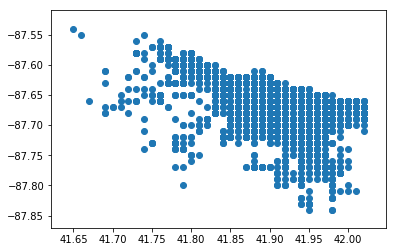

In [145]:
plt.scatter(listings.lat,listings.lon)

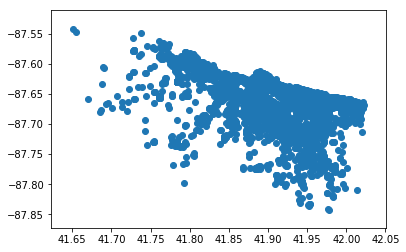

In [147]:
plt.scatter(listings.latitude,listings.longitude)

In [132]:
listings_locations.head()

,loc_id,loc,loc_id2
0,0,"(41.65, -87.54)",0
1,2,"(41.66, -87.55)",1
2,4,"(41.67, -87.66)",2
3,10,"(41.69, -87.68)",3
4,11,"(41.69, -87.67)",4


In [6]:
listings=listings.merge(listings_locations,on=['loc_id','loc'])
listings.head()

,listing_id,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,loc_id2
0,2384,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71
1,2604454,13339125,Hyde Park,1,85,1.42,3,41,7,11,2019,41.79,-87.59,"(41.789770000000004, -87.58915999999999)","(41.79, -87.59)",124,71
2,6524346,34121377,Hyde Park,2,26,0.52,1,34,7,7,2019,41.79,-87.59,"(41.79119, -87.59099)","(41.79, -87.59)",124,71
3,18549719,47172572,Hyde Park,1,127,4.77,60,96,7,2,2019,41.79,-87.59,"(41.79296, -87.59275)","(41.79, -87.59)",124,71
4,22320506,47172572,Hyde Park,1,99,5.32,60,93,7,8,2019,41.79,-87.59,"(41.793859999999995, -87.59469)","(41.79, -87.59)",124,71


### Reviews

Our reviews dataset is much simpler, since the latest information stores the entire history of Airbnb reviews by listing and date. We simply discarded information for dates outside of our interest and create a dummy variable called 'review', so when we merge the reviews to our calendar we can establish which dates of our listings we can assume have been actually rented. 

In [0]:
#Import review data
url_r = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/reviews/reviews_15_7_19.csv'
reviews = pd.read_csv(url_r)

In [0]:
reviews['month']=reviews.date.apply(lambda x: int(x[5:7]))
reviews['day']=reviews.date.apply(lambda x: int(x[8:10]))
reviews['year']=reviews.date.apply(lambda x: int(x[0:4]))
reviews.date = pd.to_datetime(reviews.date)

reviews=reviews[reviews.year > 2017]
reviews=reviews.drop(reviews[(reviews.year==2018) & (reviews.month<4)].index)
reviews=reviews.drop(reviews[(reviews.year==2018) & (reviews.month==4) & (reviews.day<15)].index)
reviews=reviews.drop(columns=['month','day','year'])
reviews['review']=1

In [9]:
reviews.head()

,listing_id,date,review
112,2384,2018-04-15,1
113,2384,2018-04-22,1
114,2384,2018-04-25,1
115,2384,2018-05-05,1
116,2384,2018-05-14,1


### Calendar

As previously explained, each scraping iteration of the calendars features prices and available dates for the near future, as provided by the host. We assumed the latest information is more likely to reflect the actual price exercised on each date. Thus, for our main analysis, we're only keeping the most recent prices made available on the website on our calendar dataset. 

However, since we're also interested in how hosts change their prices for future dates, we created another dataset named cal_change which stores listings for which different prices have been listed on different scraping dates. For now, we'll leave it aside and focus on our calendar dataset.

In [0]:
#Import calendar data from each scraping iteration (from oldest to newest)
url_c1 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_4_15.zip'
url_c2 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_5_18.zip'
url_c3 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_7_18.zip'
url_c4 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_9_14.zip'
url_c5 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_10_11.zip'
url_c6 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_11_15.zip'
url_c7 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_12_13.zip'
url_c8 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_1_17.zip'
url_c9 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_2_9.zip'
url_c10 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_3_12.zip'
url_c11 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_4_15.zip'
url_c12 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_5_19.zip'
url_c13 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_6_14.zip'
url_c14 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_7_15.zip'


calendar_1 = pd.read_csv(url_c1)
calendar_2 = pd.read_csv(url_c2)
calendar_3 = pd.read_csv(url_c3)
calendar_4 = pd.read_csv(url_c4)
calendar_5 = pd.read_csv(url_c5)
calendar_6 = pd.read_csv(url_c6)
calendar_7 = pd.read_csv(url_c7)
calendar_8 = pd.read_csv(url_c8)
calendar_9 = pd.read_csv(url_c9)
calendar_10 = pd.read_csv(url_c10)
calendar_11 = pd.read_csv(url_c11)
calendar_12 = pd.read_csv(url_c12)
calendar_13 = pd.read_csv(url_c13)
calendar_14 = pd.read_csv(url_c14)

In [0]:
#For each calendar scraping, add scraping date
calendar_1['scr_date']='2018-04-15'
calendar_2['scr_date']='2018-05-18'
calendar_3['scr_date']='2018-07-18'
calendar_4['scr_date']='2018-09-14'
calendar_5['scr_date']='2018-10-11'
calendar_6['scr_date']='2018-11-15'
calendar_7['scr_date']='2018-12-13'
calendar_8['scr_date']='2019-01-17'
calendar_9['scr_date']='2019-02-09'
calendar_10['scr_date']='2019-03-12'
calendar_11['scr_date']='2019-04-15'
calendar_12['scr_date']='2019-05-19'
calendar_13['scr_date']='2019-06-14'
calendar_14['scr_date']='2019-07-15'

In [173]:
calendar=calendar_14
calendar=calendar.append(calendar_13)
calendar=calendar.append(calendar_12)
calendar=calendar.append(calendar_11)
calendar=calendar.append(calendar_10)
calendar=calendar.append(calendar_9)
calendar=calendar.append(calendar_8)
calendar=calendar.append(calendar_7)
calendar=calendar.append(calendar_6)
calendar=calendar.append(calendar_5)
calendar=calendar.append(calendar_4)
calendar=calendar.append(calendar_3)
calendar=calendar.append(calendar_2)
calendar=calendar.append(calendar_1)

calendar=calendar[['listing_id','date','price','scr_date']]
calendar=calendar.drop_duplicates(subset=['listing_id','date','price'])
calendar=calendar.dropna(axis=0,subset=['price'])
calendar['month']=calendar.date.apply(lambda x: int(x[5:7]))
calendar['day']=calendar.date.apply(lambda x: int(x[8:10]))
calendar['year']=calendar.date.apply(lambda x: int(x[0:4]))
calendar.date = pd.to_datetime(calendar.date)
calendar.scr_date = pd.to_datetime(calendar.scr_date)
calendar.price = calendar.price.apply(lambda x: float(re.sub("[^\d\.]", "", (x[1:-3]))))
calendar.price = pd.to_numeric(calendar.price)

calendar=calendar.merge(reviews,on=['listing_id','date'],how='left')
calendar['review']=calendar['review'].fillna(0)
calendar['review']=calendar['review'].astype(int)

cal_change = calendar[calendar.duplicated(['listing_id','date'],keep=False)]
cal_change = cal_change.sort_values(by=['listing_id','date'])

calendar=calendar.drop(columns=['scr_date'])
calendar=calendar.drop_duplicates(subset=['listing_id','date'])
calendar=calendar.sort_values(by=['listing_id','date'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [13]:
calendar.head()

,listing_id,date,price,month,day,year,review
14493724,2384,2018-04-15,55.0,4,15,2018,1
14493723,2384,2018-04-16,55.0,4,16,2018,0
14493722,2384,2018-04-17,55.0,4,17,2018,0
14493721,2384,2018-04-18,55.0,4,18,2018,0
14493720,2384,2018-04-22,55.0,4,22,2018,1


In [14]:
cal_change.head()

,listing_id,date,price,scr_date,month,day,year,review
13873240,2384,2018-06-11,65.0,2018-05-18,6,11,2018,0
14493696,2384,2018-06-11,80.0,2018-04-15,6,11,2018,0
13873226,2384,2018-07-01,65.0,2018-05-18,7,1,2018,1
14493689,2384,2018-07-01,60.0,2018-04-15,7,1,2018,1
13873225,2384,2018-07-02,65.0,2018-05-18,7,2,2018,0


## Importing crimes data

We extracted our data on crimes for the city of Chicago from the Chicago Data Portal website, which amongst its Public Safety data features a dataset named "Crimes: one year prior to present", which lists all reports of criminal occurences for an entire year up to the latest update (roughly a week before the present date). For the version of this file saved on our GitHub, data spans from July 9th, 2018 to July 8th, 2019. We decided to drop data from July, 2019 since the its few entries seem incomplete, listing only a handful of occurrences.

We decided to discard crimes of certain categories such as 'deceptive practice' (e.g. credit card frauds) and 'liquor law violation' (e.g. selling alcoholic drinks without a permit), which we deemed to not be relevant when it comes to the decision-making process from both hosts and consumers in regards to rent.

When checking how many occurrences there are on our dataset for each crime category (as listed by the Chicago Data Portal), it can be seen that the most frequent crimes are related to stealing private possessions ('theft','burglary', 'robbery', 'motor vehicle theft'), criminal damage and violence ('battery', 'assault'), while the number of homicides pale in comparison (which can be at least partially attributed to less reporting, as public information would suggest many more homicides happened on Chicago for that time period).

Since some types of crimes are much more reported than others, the relation between aggregate criminality and prices might be unclear and dominated by the categories with more representation. For example, we'd expect the correlation between price and nearby homicides to be negative, but the correlation between theft and price might actually be positive since higher rent prices are likely to be present in richer areas or more populated areas, where thefts might be more present (or at least, reported more often).

To make a more thorough analysis, we'll deal with the full set of criminal occurrences as well as subsets for crimes related to physical aggression, stealing private property and homicides.

Like on our listings dataset, we rounded locations (latitude and longitude) to 2 decimals, reducing over a hundred thousand criminal reports to 708 locations.

In [128]:
url_cr = "https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/crimes/crimes.csv"
crimes = pd.read_csv(url_cr)
crimes = crimes[['DATE  OF OCCURRENCE','LATITUDE','LONGITUDE','ARREST',' PRIMARY DESCRIPTION']]
crimes = crimes.rename(index=str, columns={"DATE  OF OCCURRENCE": "date","LONGITUDE": "longitude","LATITUDE": "latitude"," PRIMARY DESCRIPTION": "desc", "ARREST": "arrest"})
crimes = crimes[crimes.desc!="CONCEALED CARRY LICENSE VIOLATION"]
crimes = crimes[crimes.desc!="DECEPTIVE PRACTICE"]
crimes = crimes[crimes.desc!="INTERFERENCE WITH PUBLIC OFFICER"]
crimes = crimes[crimes.desc!="OBSCENITY"]
crimes = crimes[crimes.desc!="NON-CRIMINAL"]
crimes = crimes[crimes.desc!="NON-CRIMINAL (SUBJECT SPECIFIED)"]
crimes = crimes[crimes.desc!="LIQUOR LAW VIOLATION"]
crimes = crimes[crimes.desc!="PUBLIC INDECENCY"]

crimes['lat']=crimes.latitude.round(2)
crimes['lon']=crimes.longitude.round(2)
crimes['location'] = list(zip(crimes.latitude, crimes.longitude))
crimes['loc'] = list(zip(crimes.lat, crimes.lon))
crimes = crimes.assign(loc_id=(crimes['loc'].astype('category').cat.codes))
crimes.arrest = crimes.arrest.apply(lambda x: 0 if x=="N" else 1)
crimes.date = crimes.date.apply(lambda x: x[0:10])
crimes.date = pd.to_datetime(crimes.date)
crimes['date_str'] = crimes.date.astype('str')
crimes['month']=crimes.date_str.apply(lambda x: int(x[5:7]))
crimes['day']=crimes.date_str.apply(lambda x: int(x[8:10]))
crimes['year']=crimes.date_str.apply(lambda x: int(x[0:4]))

crimes=crimes.drop(columns=['date_str'])
#Dropping incomplete observations
crimes=crimes.drop(crimes[(crimes.year==2019) & (crimes.month==7)].index)

crimes=crimes.dropna(axis=0)
crimes=crimes.sort_values(by='date')
print(crimes['desc'].value_counts())

THEFT                         60775
BATTERY                       48332
CRIMINAL DAMAGE               26229
ASSAULT                       20093
OTHER OFFENSE                 16370
NARCOTICS                     12648
BURGLARY                      10272
MOTOR VEHICLE THEFT            9277
ROBBERY                        8448
CRIMINAL TRESPASS              6582
WEAPONS VIOLATION              5736
OFFENSE INVOLVING CHILDREN     2138
CRIM SEXUAL ASSAULT            1542
PUBLIC PEACE VIOLATION         1440
SEX OFFENSE                    1129
PROSTITUTION                    666
HOMICIDE                        551
ARSON                           357
STALKING                        200
INTIMIDATION                    182
GAMBLING                        168
KIDNAPPING                      161
HUMAN TRAFFICKING                14
OTHER NARCOTIC VIOLATION          4
Name: desc, dtype: int64


In [0]:
homicides=crimes[crimes.desc=="HOMICIDE"]
homicides=homicides.drop(columns=['desc'])

stealing=crimes[crimes.desc.isin(["BURGLARY", "THEFT", "ROBBERY", "MOTOR VEHICLE THEFT"])]
stealing=stealing.drop(columns=['desc'])

aggression=crimes[crimes.desc.isin(["BATTERY", "ASSAULT"])]
aggression=aggression.drop(columns=['desc'])

crimes=crimes.drop(columns=['desc'])

Like we did for our listings, we'll create dataframe pairing locations to their id's (both the original and our "corrected" version)

In [17]:
crimes_locations = crimes[['loc','loc_id']]
crimes_locations = crimes_locations.drop_duplicates('loc_id')
crimes_locations = crimes_locations.set_index('loc_id')
crimes_locations = crimes_locations.sort_index()
crimes_locations = crimes_locations.reset_index()
crimes_locations['crim_loc_id2']=crimes_locations.index
crim_locs=list(crimes_locations['loc'])
len(crim_locs)

708

In [18]:
homicides_locations = homicides[['loc','loc_id']]
homicides_locations = homicides_locations.drop_duplicates('loc_id')
homicides_locations = homicides_locations.set_index('loc_id')
homicides_locations = homicides_locations.sort_index()
homicides_locations = homicides_locations.reset_index()
homicides_locations['crim_loc_id2']=homicides_locations.index
homi_locs=list(homicides_locations['loc'])
len(homi_locs)

244

In [19]:
aggression_locations = aggression[['loc','loc_id']]
aggression_locations = aggression_locations.drop_duplicates('loc_id')
aggression_locations = aggression_locations.set_index('loc_id')
aggression_locations = aggression_locations.sort_index()
aggression_locations = aggression_locations.reset_index()
aggression_locations['crim_loc_id2']=aggression_locations.index
aggr_locs=list(aggression_locations['loc'])
len(aggr_locs)

682

In [20]:
stealing_locations = stealing[['loc','loc_id']]
stealing_locations = stealing_locations.drop_duplicates('loc_id')
stealing_locations = stealing_locations.set_index('loc_id')
stealing_locations = stealing_locations.sort_index()
stealing_locations = stealing_locations.reset_index()
stealing_locations['crim_loc_id2']=stealing_locations.index
stea_locs=list(stealing_locations['loc'])
len(stea_locs)

681

In [0]:
crimes = crimes.merge(crimes_locations,on=['loc_id','loc'])
homicides = homicides.merge(homicides_locations,on=['loc_id','loc'])
aggression = aggression.merge(aggression_locations,on=['loc_id','loc'])
stealing = stealing.merge(stealing_locations,on=['loc_id','loc'])
#crimes.sort_values(by='date')

Now we'll create dataframes for counting criminal occurences for each date and listing the locations in which those crimes happened 

Crimes by date:

In [22]:
crimes_date=crimes[['date','loc_id','crim_loc_id2']]
crimes_date=crimes_date.groupby('date').agg(lambda x: list(x))
crimes_date['crimes_count_date']=np.nan
for i in range(len(crimes_date)):
  crimes_date.crimes_count_date.iloc[i]=len(list(crimes_date.loc_id.iloc[i]))
  crimes_date.loc_id.iloc[i]=np.unique(list(crimes_date.loc_id.iloc[i]))
  crimes_date.crim_loc_id2.iloc[i]=np.unique(list(crimes_date.crim_loc_id2.iloc[i]))
crimes_date.crimes_count_date=crimes_date.crimes_count_date.astype(int)
crimes_date=crimes_date.reset_index()
crimes_date=crimes_date.rename(index=str, columns={"loc_id": "crim_loc_id"})
crimes_date.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,crim_loc_id,crim_loc_id2,crimes_count_date
0,2018-07-09,"[0, 5883, 5900, 5903, 5904, 5905, 5906, 5908, ...","[0, 27, 34, 37, 38, 39, 40, 42, 47, 48, 49, 50...",622
1,2018-07-10,"[0, 5885, 5892, 5900, 5902, 5906, 5907, 5908, ...","[0, 28, 30, 34, 36, 40, 41, 42, 44, 46, 47, 49...",732
2,2018-07-11,"[0, 5883, 5893, 5894, 5900, 5903, 5904, 5905, ...","[0, 27, 31, 32, 34, 37, 38, 39, 41, 43, 44, 45...",665
3,2018-07-12,"[0, 5893, 5897, 5900, 5907, 5908, 5913, 5915, ...","[0, 31, 33, 34, 41, 42, 47, 49, 51, 57, 58, 60...",732
4,2018-07-13,"[0, 5890, 5892, 5894, 5903, 5904, 5905, 5906, ...","[0, 29, 30, 32, 37, 38, 39, 40, 41, 46, 47, 51...",753


In [23]:
homicides_date=homicides[['date','loc_id','crim_loc_id2']]
homicides_date=homicides_date.groupby('date').agg(lambda x: list(x))
homicides_date['homicides_count_date']=np.nan
for i in range(len(homicides_date)):
  homicides_date.homicides_count_date.iloc[i]=len(list(homicides_date.loc_id.iloc[i]))
  homicides_date.loc_id.iloc[i]=np.unique(list(homicides_date.loc_id.iloc[i]))
  homicides_date.crim_loc_id2.iloc[i]=np.unique(list(homicides_date.crim_loc_id2.iloc[i]))
homicides_date.homicides_count_date=homicides_date.homicides_count_date.astype(int)
homicides_date=homicides_date.reset_index()
homicides_date=homicides_date.rename(index=str, columns={"loc_id": "homi_loc_id"})
homicides_date.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,homi_loc_id,crim_loc_id2,homicides_count_date
0,2018-07-09,[6088],[108],1
1,2018-07-10,"[6001, 6101]","[45, 115]",2
2,2018-07-11,"[5980, 6029, 6103]","[38, 66, 117]",4
3,2018-07-12,"[5917, 6023, 6104, 6202, 6463]","[11, 60, 118, 156, 238]",5
4,2018-07-13,[6068],[95],1


In [24]:
aggression_date=aggression[['date','loc_id','crim_loc_id2']]
aggression_date=aggression_date.groupby('date').agg(lambda x: list(x))
aggression_date['aggression_count_date']=np.nan
for i in range(len(aggression_date)):
  aggression_date.aggression_count_date.iloc[i]=len(list(aggression_date.loc_id.iloc[i]))
  aggression_date.loc_id.iloc[i]=np.unique(list(aggression_date.loc_id.iloc[i]))
  aggression_date.crim_loc_id2.iloc[i]=np.unique(list(aggression_date.crim_loc_id2.iloc[i]))
aggression_date.aggression_count_date=aggression_date.aggression_count_date.astype(int)
aggression_date=aggression_date.reset_index()
aggression_date=aggression_date.rename(index=str, columns={"loc_id": "homi_loc_id"})
aggression_date.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,homi_loc_id,crim_loc_id2,aggression_count_date
0,2018-07-09,"[0, 5883, 5903, 5904, 5906, 5915, 5916, 5917, ...","[0, 19, 29, 30, 32, 41, 42, 43, 67, 70, 77, 78...",160
1,2018-07-10,"[0, 5900, 5906, 5907, 5908, 5915, 5916, 5925, ...","[0, 26, 32, 33, 34, 41, 42, 51, 54, 57, 62, 66...",193
2,2018-07-11,"[0, 5893, 5904, 5909, 5917, 5923, 5924, 5925, ...","[0, 23, 30, 35, 43, 49, 50, 51, 52, 53, 54, 65...",196
3,2018-07-12,"[0, 5893, 5907, 5908, 5926, 5927, 5929, 5938, ...","[0, 23, 33, 34, 52, 53, 55, 64, 70, 71, 72, 78...",200
4,2018-07-13,"[0, 5890, 5892, 5903, 5904, 5917, 5926, 5927, ...","[0, 21, 22, 29, 30, 43, 52, 53, 54, 55, 64, 77...",215


In [25]:
stealing_date=stealing[['date','loc_id','crim_loc_id2']]
stealing_date=stealing_date.groupby('date').agg(lambda x: list(x))
stealing_date['stealing_count_date']=np.nan
for i in range(len(stealing_date)):
  stealing_date.stealing_count_date.iloc[i]=len(list(stealing_date.loc_id.iloc[i]))
  stealing_date.loc_id.iloc[i]=np.unique(list(stealing_date.loc_id.iloc[i]))
  stealing_date.crim_loc_id2.iloc[i]=np.unique(list(stealing_date.crim_loc_id2.iloc[i]))
stealing_date.stealing_count_date=stealing_date.stealing_count_date.astype(int)
stealing_date=stealing_date.reset_index()
stealing_date=stealing_date.rename(index=str, columns={"loc_id": "homi_loc_id"})
stealing_date.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,homi_loc_id,crim_loc_id2,stealing_count_date
0,2018-07-09,"[0, 5905, 5906, 5913, 5915, 5928, 5930, 5933, ...","[0, 32, 33, 40, 42, 55, 57, 60, 82, 84, 90, 92...",259
1,2018-07-10,"[0, 5892, 5913, 5915, 5916, 5920, 5922, 5924, ...","[0, 23, 40, 42, 43, 47, 49, 51, 52, 55, 59, 60...",317
2,2018-07-11,"[0, 5883, 5905, 5911, 5917, 5923, 5926, 5927, ...","[0, 20, 32, 38, 44, 50, 53, 54, 60, 65, 67, 68...",264
3,2018-07-12,"[0, 5893, 5900, 5913, 5917, 5924, 5926, 5928, ...","[0, 24, 27, 40, 44, 51, 53, 55, 68, 89, 91, 94...",310
4,2018-07-13,"[0, 5903, 5904, 5905, 5906, 5907, 5913, 5923, ...","[0, 30, 31, 32, 33, 34, 40, 50, 55, 69, 80, 82...",328


In [0]:
#plt.plot(crimes_date.index,crimes_date.crimes_count_date)

In [0]:
#plt.plot(homicides_date.index,homicides_date.homicides_count_date)

In [0]:
#plt.plot(aggression_date.index,aggression_date.aggression_count_date)

In [0]:
#plt.plot(stealing_date.index,stealing_date.stealing_count_date)

Crimes by location:

In [30]:
crimes_loc=crimes[['loc_id','crim_loc_id2']]
crimes_loc=crimes_loc.groupby(['loc_id']).agg(lambda x: list(x))
crimes_loc['crimes_count_loc']=np.nan
for i in range(len(crimes_loc)):
  crimes_loc.crimes_count_loc.iloc[i]=len(list(crimes_loc.crim_loc_id2.iloc[i]))
crimes_loc.crimes_count_loc=crimes_loc.crimes_count_loc.astype(int)
crimes_loc=crimes_loc.reset_index()
crimes_loc.crim_loc_id2=crimes_loc.index
crimes_loc=crimes_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
homicides_loc=homicides[['loc_id','crim_loc_id2']]
homicides_loc=homicides_loc.groupby(['loc_id']).agg(lambda x: list(x))
homicides_loc['homicides_count_loc']=np.nan
for i in range(len(homicides_loc)):
  homicides_loc.homicides_count_loc.iloc[i]=len(list(homicides_loc.crim_loc_id2.iloc[i]))
homicides_loc.homicides_count_loc=homicides_loc.homicides_count_loc.astype(int)
homicides_loc=homicides_loc.reset_index()
homicides_loc.crim_loc_id2=homicides_loc.index
homicides_loc=homicides_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
aggression_loc=aggression[['loc_id','crim_loc_id2']]
aggression_loc=aggression_loc.groupby(['loc_id']).agg(lambda x: list(x))
aggression_loc['aggression_count_loc']=np.nan
for i in range(len(aggression_loc)):
  aggression_loc.aggression_count_loc.iloc[i]=len(list(aggression_loc.crim_loc_id2.iloc[i]))
aggression_loc.aggression_count_loc=aggression_loc.aggression_count_loc.astype(int)
aggression_loc=aggression_loc.reset_index()
aggression_loc.crim_loc_id2=aggression_loc.index
aggression_loc=aggression_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
stealing_loc=stealing[['loc_id','crim_loc_id2']]
stealing_loc=stealing_loc.groupby(['loc_id']).agg(lambda x: list(x))
stealing_loc['stealing_count_loc']=np.nan
for i in range(len(stealing_loc)):
  stealing_loc.stealing_count_loc.iloc[i]=len(list(stealing_loc.crim_loc_id2.iloc[i]))
stealing_loc.stealing_count_loc=stealing_loc.stealing_count_loc.astype(int)
stealing_loc=stealing_loc.reset_index()
stealing_loc.crim_loc_id2=stealing_loc.index
stealing_loc=stealing_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#plt.plot(crimes_loc.index,crimes_loc.crimes_count_loc)

In [0]:
#plt.plot(homicides_loc.index,homicides_loc.homicides_count_loc)

In [0]:
#plt.plot(aggression_loc.index,aggression_loc.aggression_count_loc)

In [0]:
#plt.plot(stealing_loc.index,stealing_loc.stealing_count_loc)

## Calculating distances between Airbnb listings and criminal occurrences

We're interested in knowing the criminal activity surrounding each Airbnb listing. To do that, we'll calculate the distance between each unique location on our listings database and each unique location on our criminal occurrence datasets.

In [0]:
def distance(a,b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees). Output in KM
    """
    lat1 = a[0]
    lat2 = b[0]
    lon1 = a[1]
    lon2 = b[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [39]:
dist_cr=[None]*len(list_locs)
for i in range(len(list_locs)):
  a=[None]*len(crim_locs)
  x=list_locs[i]
  for j in range(len(crim_locs)):
    a[j]=round(distance(x,crim_locs[j]),2)
  dist_cr[i]=a
  
dist_cr=pd.DataFrame(dist_cr)
dist_cr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,27.71,4.15,17.39,3.73,3.34,6.00,5.55,2.22,42.94,6.94,42.99,46.14,41.98,23.29,16.13,18.84,3.44,49.74,49.54,24.61,46.97,36.57,48.54,3.44,4.00,45.88,41.97,0.00,9.21,5.92,5.82,4.99,0.83,6.65,8.38,7.56,6.74,5.92,5.11,1.11,...,43.42,42.14,40.26,39.61,42.34,47.15,44.80,44.36,43.93,41.28,44.89,42.63,42.44,43.49,44.70,43.70,38.89,43.33,40.64,46.83,44.48,44.09,26.00,45.69,3.50,5.46,49.92,6.74,47.23,19.35,45.05,16.40,4.75,43.98,4.71,5.11,663.84,45.59,45.71,44.88
1,26.42,3.50,16.12,2.37,2.00,4.71,4.16,1.39,41.55,5.55,41.61,44.76,40.64,21.98,15.12,17.59,2.78,48.35,48.16,23.23,45.59,35.18,47.15,2.22,2.73,44.50,40.61,1.39,8.31,5.46,5.11,4.30,1.11,5.92,7.48,6.65,5.82,4.98,4.15,0.83,...,42.03,40.76,38.91,38.27,40.97,45.76,43.41,42.98,42.55,39.93,43.51,41.28,41.11,42.17,43.33,42.34,37.62,41.97,39.31,45.46,43.11,42.72,24.61,44.33,2.49,4.30,48.53,6.23,45.86,18.10,43.67,15.32,4.16,42.63,3.34,4.71,664.30,44.21,44.32,43.49
2,24.59,6.23,8.33,8.38,7.48,5.11,7.01,9.97,36.21,6.70,35.89,38.33,37.15,14.39,5.92,9.41,10.85,42.03,42.14,17.66,39.27,29.44,41.35,9.20,6.64,37.86,36.53,10.21,1.39,5.33,4.71,5.46,9.40,4.00,2.00,2.73,3.50,4.30,5.11,10.03,...,36.93,36.11,35.10,34.83,36.73,39.98,38.27,37.97,37.69,36.19,38.74,37.44,38.03,39.14,39.09,38.02,35.59,37.81,35.93,40.85,38.48,38.24,18.99,40.17,6.74,4.98,42.72,4.71,41.11,17.66,37.46,6.22,11.84,38.70,6.74,6.00,660.19,37.89,38.91,37.62
3,22.62,8.70,5.55,10.03,9.40,6.74,8.30,11.84,33.52,7.55,33.16,35.56,34.72,11.62,4.30,6.68,12.51,39.26,39.39,15.04,36.50,26.73,38.61,10.85,8.60,35.09,34.01,12.45,4.16,8.04,7.32,8.00,11.68,6.68,4.71,5.33,6.00,6.70,7.43,12.10,...,34.27,33.51,32.63,32.42,34.18,37.25,35.60,35.32,35.05,33.73,36.11,34.95,35.67,36.78,36.53,35.45,33.45,35.27,33.52,38.24,35.88,35.65,16.34,37.62,8.95,7.01,39.98,7.47,38.48,16.27,34.70,4.15,13.29,36.19,8.38,8.66,661.15,35.12,36.21,34.89
4,22.48,8.00,6.08,9.20,8.60,5.92,7.47,11.02,33.84,6.73,33.52,36.01,34.83,12.17,5.11,7.32,11.68,39.71,39.79,15.29,36.94,27.08,38.99,10.03,7.80,35.57,34.18,11.68,3.73,7.47,6.68,7.32,10.91,6.09,4.16,4.71,5.33,6.00,6.70,11.30,...,34.56,33.74,32.76,32.51,34.37,37.62,35.90,35.60,35.32,33.86,36.37,35.10,35.74,36.84,36.73,35.65,33.40,35.45,33.61,38.48,36.11,35.88,16.61,37.81,8.19,6.22,40.36,6.94,38.74,15.91,35.12,4.98,12.46,36.35,7.56,8.04,661.60,35.56,36.54,35.27


In [40]:
dist1_cr=dist_cr[dist_cr<=1].notnull().astype('int')
dist1_cr=dist1_cr.fillna(0)
dist1_cr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
dist2_cr=dist_cr[dist_cr<=2].notnull().astype('int')
dist2_cr=dist2_cr.fillna(0)
dist2_cr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
dist5_cr=dist_cr[dist_cr<=5].notnull().astype('int')
dist5_cr=dist5_cr.fillna(0)
dist5_cr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [43]:
dist_hm=[None]*len(list_locs)
for i in range(len(list_locs)):
  a=[None]*len(homi_locs)
  x=list_locs[i]
  for j in range(len(homi_locs)):
    a[j]=round(distance(x,homi_locs[j]),2)
  dist_hm[i]=a
  
dist_hm=pd.DataFrame(dist_hm)
dist_hm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243
0,4.99,6.65,8.38,6.74,5.92,5.11,8.60,7.01,10.51,9.73,8.19,7.44,11.68,10.91,9.42,8.70,8.00,7.32,15.17,12.14,10.69,9.32,8.66,8.04,5.80,5.56,10.65,10.02,9.42,8.85,6.67,12.64,12.00,10.79,9.24,8.82,8.17,7.78,13.99,13.36,...,29.86,36.96,36.02,35.13,34.71,34.30,33.90,33.53,36.95,36.08,34.89,34.18,33.53,32.02,38.33,35.89,34.87,33.30,37.25,37.90,37.24,36.93,35.66,38.58,38.27,36.95,41.35,38.02,41.25,42.75,42.53,41.39,40.06,41.45,42.98,9.40,11.41,23.59,35.19,40.37
1,4.30,5.92,7.48,5.82,4.98,4.15,7.56,5.92,9.40,8.60,7.01,6.23,10.51,9.73,8.19,7.43,6.70,6.00,14.01,10.91,9.42,8.00,7.32,6.68,4.52,4.52,9.31,8.66,8.04,7.47,5.62,11.31,10.65,9.41,7.86,7.45,6.88,6.72,12.64,12.00,...,28.58,35.57,34.63,33.75,33.33,32.92,32.53,32.16,35.57,34.70,33.53,32.82,32.19,30.75,36.95,34.53,33.53,32.02,35.89,36.54,35.90,35.60,34.37,37.24,36.93,35.66,39.98,36.73,39.97,41.45,41.25,40.06,38.74,40.17,41.68,8.38,10.16,22.20,33.84,39.00
2,5.46,4.00,2.00,3.50,4.30,5.11,1.66,3.32,1.11,1.39,2.73,3.50,2.37,2.22,2.78,3.34,4.00,4.71,5.33,3.44,3.44,4.16,4.71,5.33,8.95,10.51,4.75,5.10,5.55,6.08,10.91,5.56,5.62,6.09,7.47,8.04,9.31,11.41,6.72,6.67,...,26.80,30.12,29.53,29.01,28.78,28.58,28.40,28.24,30.57,30.08,29.49,29.21,29.02,29.02,31.90,30.58,30.21,30.07,31.83,32.76,32.51,32.42,32.26,33.73,33.61,33.36,35.66,34.47,37.81,38.95,38.93,36.93,35.74,37.82,39.00,0.83,3.34,17.19,30.31,34.58
3,8.00,6.68,4.71,6.00,6.70,7.43,4.00,5.46,2.00,2.73,4.30,5.11,0.83,1.66,3.32,4.15,4.98,5.81,2.73,1.39,2.73,4.30,5.10,5.92,10.03,11.68,4.00,4.71,5.46,6.22,11.83,3.73,4.16,5.33,7.43,8.18,9.72,12.09,4.52,4.75,...,24.81,27.44,26.88,26.42,26.22,26.05,25.91,25.79,27.94,27.50,27.01,26.80,26.70,27.01,29.26,28.11,27.85,28.00,29.34,30.31,30.13,30.07,30.13,31.31,31.23,31.18,33.10,32.29,35.62,36.69,36.70,34.56,33.40,35.59,36.70,3.34,2.00,14.67,27.91,32.02
4,7.32,6.09,4.16,5.33,6.00,6.70,3.34,4.71,1.39,2.00,3.50,4.30,0.00,0.83,2.49,3.32,4.15,4.98,3.50,1.11,2.00,3.50,4.30,5.10,9.20,10.85,3.34,4.00,4.71,5.46,11.02,3.44,3.73,4.71,6.70,7.43,8.95,11.30,4.45,4.52,...,24.69,27.75,27.15,26.64,26.42,26.22,26.05,25.91,28.20,27.71,27.15,26.89,26.74,26.89,29.52,28.24,27.91,27.91,29.49,30.43,30.21,30.13,30.07,31.41,31.31,31.15,33.29,32.26,35.59,36.70,36.69,34.63,33.45,35.58,36.73,2.78,1.39,14.83,28.00,32.22


In [0]:
dist1_hm=dist_hm[dist_hm<=1].notnull().astype('int')
dist1_hm=dist1_hm.fillna(0)
#dist1_hm.head()

dist2_hm=dist_cr[dist_hm<=2].notnull().astype('int')
dist2_hm=dist2_cr.fillna(0)
#dist2_hm.head()

dist5_hm=dist_hm[dist_hm<=5].notnull().astype('int')
dist5_hm=dist5_hm.fillna(0)
#dist5_hm.head()


In [45]:
dist_ag=[None]*len(list_locs)
for i in range(len(list_locs)):
  a=[None]*len(aggr_locs)
  x=list_locs[i]
  for j in range(len(aggr_locs)):
    a[j]=round(distance(x,aggr_locs[j]),2)
  dist_ag[i]=a
  
dist_ag=pd.DataFrame(dist_ag)
dist_ag.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681
0,27.71,4.15,17.39,3.34,6.00,2.22,6.94,46.14,41.98,23.29,16.13,18.84,3.44,49.54,24.61,46.97,3.44,45.88,41.97,0.00,9.21,5.92,5.82,4.99,0.83,6.65,8.38,7.56,6.74,5.92,5.11,1.11,8.60,7.80,7.01,2.78,14.51,12.10,11.30,10.51,...,42.50,40.65,40.22,35.27,46.44,45.91,43.89,40.37,37.43,36.53,46.77,43.86,43.42,42.14,40.26,39.61,42.34,47.15,44.80,44.36,43.93,41.28,44.89,42.63,42.44,43.49,44.70,43.70,38.89,43.33,40.64,46.83,44.48,44.09,5.46,49.92,47.23,4.75,5.11,663.84
1,26.42,3.50,16.12,2.00,4.71,1.39,5.55,44.76,40.64,21.98,15.12,17.59,2.78,48.16,23.23,45.59,2.22,44.50,40.61,1.39,8.31,5.46,5.11,4.30,1.11,5.92,7.48,6.65,5.82,4.98,4.15,0.83,7.56,6.74,5.92,1.39,13.47,11.02,10.21,9.40,...,41.12,39.27,38.84,34.01,45.05,44.52,42.50,39.00,36.11,35.27,45.39,42.48,42.03,40.76,38.91,38.27,40.97,45.76,43.41,42.98,42.55,39.93,43.51,41.28,41.11,42.17,43.33,42.34,37.62,41.97,39.31,45.46,43.11,42.72,4.30,48.53,45.86,4.16,4.71,664.30
2,24.59,6.23,8.33,7.48,5.11,9.97,6.70,38.33,37.15,14.39,5.92,9.41,10.85,42.14,17.66,39.27,9.20,37.86,36.53,10.21,1.39,5.33,4.71,5.46,9.40,4.00,2.00,2.73,3.50,4.30,5.11,10.03,1.66,2.49,3.32,8.31,4.30,2.00,1.39,1.11,...,35.53,34.27,34.00,32.34,38.84,38.42,36.89,34.58,33.40,33.40,39.39,37.24,36.93,36.11,35.10,34.83,36.73,39.98,38.27,37.97,37.69,36.19,38.74,37.44,38.03,39.14,39.09,38.02,35.59,37.81,35.93,40.85,38.48,38.24,4.98,42.72,41.11,11.84,6.00,660.19
3,22.62,8.70,5.55,9.40,6.74,11.84,7.55,35.56,34.72,11.62,4.30,6.68,12.51,39.39,15.04,36.50,10.85,35.09,34.01,12.45,4.16,8.04,7.32,8.00,11.68,6.68,4.71,5.33,6.00,6.70,7.43,12.10,4.00,4.71,5.46,10.21,2.73,1.11,1.39,2.00,...,32.82,31.63,31.38,30.31,36.08,35.67,34.17,32.02,31.13,31.31,36.64,34.56,34.27,33.51,32.63,32.42,34.18,37.25,35.60,35.32,35.05,33.73,36.11,34.95,35.67,36.78,36.53,35.45,33.45,35.27,33.52,38.24,35.88,35.65,7.01,39.98,38.48,13.29,8.66,661.15
4,22.48,8.00,6.08,8.60,5.92,11.02,6.73,36.01,34.83,12.17,5.11,7.32,11.68,39.79,15.29,36.94,10.03,35.57,34.18,11.68,3.73,7.47,6.68,7.32,10.91,6.09,4.16,4.71,5.33,6.00,6.70,11.30,3.34,4.00,4.71,9.40,3.50,1.39,1.11,1.39,...,33.16,31.90,31.63,30.21,36.50,36.08,34.52,32.22,31.15,31.23,37.04,34.86,34.56,33.74,32.76,32.51,34.37,37.62,35.90,35.60,35.32,33.86,36.37,35.10,35.74,36.84,36.73,35.65,33.40,35.45,33.61,38.48,36.11,35.88,6.22,40.36,38.74,12.46,8.04,661.60


In [0]:
dist1_ag=dist_ag[dist_ag<=1].notnull().astype('int')
dist1_ag=dist1_ag.fillna(0)
#dist1_ag.head()

dist2_ag=dist_ag[dist_ag<=2].notnull().astype('int')
dist2_ag=dist2_ag.fillna(0)
#dist2_ag.head()

dist5_ag=dist_ag[dist_ag<=5].notnull().astype('int')
dist5_ag=dist5_ag.fillna(0)
#dist5_ag.head()

In [47]:
dist_st=[None]*len(list_locs)
for i in range(len(list_locs)):
  a=[None]*len(stea_locs)
  x=list_locs[i]
  for j in range(len(stea_locs)):
    a[j]=round(distance(x,stea_locs[j]),2)
  dist_st[i]=a
  
dist_st=pd.DataFrame(dist_st)
dist_st.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680
0,27.71,17.39,3.73,6.00,2.22,42.94,6.94,42.99,46.14,41.98,16.13,18.84,49.74,24.61,46.97,36.57,48.54,3.44,4.00,41.97,0.00,9.21,5.92,5.82,4.99,0.83,6.65,8.38,7.56,6.74,5.92,5.11,1.11,8.60,7.80,7.01,2.78,14.51,12.10,11.30,...,40.65,40.22,46.44,45.91,45.39,43.89,40.37,37.43,36.53,46.77,43.86,43.42,42.14,40.26,39.61,42.34,47.15,44.80,44.36,43.93,41.28,44.89,42.63,42.44,43.49,44.70,43.70,38.89,43.33,40.64,46.83,44.48,44.09,26.00,6.74,47.23,19.35,45.05,16.40,45.71
1,26.42,16.12,2.37,4.71,1.39,41.55,5.55,41.61,44.76,40.64,15.12,17.59,48.35,23.23,45.59,35.18,47.15,2.22,2.73,40.61,1.39,8.31,5.46,5.11,4.30,1.11,5.92,7.48,6.65,5.82,4.98,4.15,0.83,7.56,6.74,5.92,1.39,13.47,11.02,10.21,...,39.27,38.84,45.05,44.52,44.00,42.50,39.00,36.11,35.27,45.39,42.48,42.03,40.76,38.91,38.27,40.97,45.76,43.41,42.98,42.55,39.93,43.51,41.28,41.11,42.17,43.33,42.34,37.62,41.97,39.31,45.46,43.11,42.72,24.61,6.23,45.86,18.10,43.67,15.32,44.32
2,24.59,8.33,8.38,5.11,9.97,36.21,6.70,35.89,38.33,37.15,5.92,9.41,42.03,17.66,39.27,29.44,41.35,9.20,6.64,36.53,10.21,1.39,5.33,4.71,5.46,9.40,4.00,2.00,2.73,3.50,4.30,5.11,10.03,1.66,2.49,3.32,8.31,4.30,2.00,1.39,...,34.27,34.00,38.84,38.42,38.02,36.89,34.58,33.40,33.40,39.39,37.24,36.93,36.11,35.10,34.83,36.73,39.98,38.27,37.97,37.69,36.19,38.74,37.44,38.03,39.14,39.09,38.02,35.59,37.81,35.93,40.85,38.48,38.24,18.99,4.71,41.11,17.66,37.46,6.22,38.91
3,22.62,5.55,10.03,6.74,11.84,33.52,7.55,33.16,35.56,34.72,4.30,6.68,39.26,15.04,36.50,26.73,38.61,10.85,8.60,34.01,12.45,4.16,8.04,7.32,8.00,11.68,6.68,4.71,5.33,6.00,6.70,7.43,12.10,4.00,4.71,5.46,10.21,2.73,1.11,1.39,...,31.63,31.38,36.08,35.67,35.27,34.17,32.02,31.13,31.31,36.64,34.56,34.27,33.51,32.63,32.42,34.18,37.25,35.60,35.32,35.05,33.73,36.11,34.95,35.67,36.78,36.53,35.45,33.45,35.27,33.52,38.24,35.88,35.65,16.34,7.47,38.48,16.27,34.70,4.15,36.21
4,22.48,6.08,9.20,5.92,11.02,33.84,6.73,33.52,36.01,34.83,5.11,7.32,39.71,15.29,36.94,27.08,38.99,10.03,7.80,34.18,11.68,3.73,7.47,6.68,7.32,10.91,6.09,4.16,4.71,5.33,6.00,6.70,11.30,3.34,4.00,4.71,9.40,3.50,1.39,1.11,...,31.90,31.63,36.50,36.08,35.67,34.52,32.22,31.15,31.23,37.04,34.86,34.56,33.74,32.76,32.51,34.37,37.62,35.90,35.60,35.32,33.86,36.37,35.10,35.74,36.84,36.73,35.65,33.40,35.45,33.61,38.48,36.11,35.88,16.61,6.94,38.74,15.91,35.12,4.98,36.54


In [0]:
dist1_st=dist_hm[dist_st<=1].notnull().astype('int')
dist1_st=dist1_hm.fillna(0)
#dist1_st.head()

dist2_st=dist_cr[dist_st<=2].notnull().astype('int')
dist2_st=dist2_cr.fillna(0)
#dist2_st.head()

dist5_st=dist_st[dist_st<=5].notnull().astype('int')
dist5_st=dist5_st.fillna(0)
#dist5_st.head()

##Merging listings, calendars reviews to build our complete Airbnb database

In [0]:
airbnb=calendar.merge(listings,on=['listing_id'],how='inner')
airbnb = airbnb[airbnb.review==1]
airbnb = airbnb.drop(columns=['review'])
airbnb = pd.concat([airbnb, pd.get_dummies(airbnb.room_type, prefix='room_type', drop_first=True)], axis=1)
airbnb = pd.concat([airbnb, pd.get_dummies(airbnb.neighbourhood, drop_first=True)], axis=1)

In [0]:
airbnb_cr=airbnb.merge(crimes_date,on=['date'])
airbnb_cr['loc_id'] = airbnb_cr.loc_id2
airbnb_cr['crim_loc_id'] = airbnb_cr.crim_loc_id2
airbnb_cr = airbnb_cr.drop(columns=['loc_id2','crim_loc_id2'])
airbnb_cr = airbnb_cr.assign(date_id=(airbnb_cr['date'].astype('category').cat.codes))
airbnb_cr = airbnb_cr.rename(index=str, columns={"crim_loc_id": "crimes_that_date"})
airbnb_cr = airbnb_cr.sort_values(by=['listing_id','date'])

In [0]:
airbnb_hm=airbnb.merge(homicides_date,on=['date'])
airbnb_hm['loc_id'] = airbnb_hm.loc_id2
airbnb_hm['crim_loc_id'] = airbnb_hm.crim_loc_id2
airbnb_hm = airbnb_hm.drop(columns=['loc_id2','crim_loc_id2'])
airbnb_hm = airbnb_hm.assign(date_id=(airbnb_hm['date'].astype('category').cat.codes))
airbnb_hm = airbnb_hm.rename(index=str, columns={"crim_loc_id": "crimes_that_date"})
airbnb_hm = airbnb_hm.sort_values(by=['listing_id','date'])

In [0]:
airbnb_ag=airbnb.merge(aggression_date,on=['date'])
airbnb_ag['loc_id'] = airbnb_ag.loc_id2
airbnb_ag['crim_loc_id'] = airbnb_ag.crim_loc_id2
airbnb_ag = airbnb_ag.drop(columns=['loc_id2','crim_loc_id2'])
airbnb_ag = airbnb_ag.assign(date_id=(airbnb_ag['date'].astype('category').cat.codes))
airbnb_ag = airbnb_ag.rename(index=str, columns={"crim_loc_id": "crimes_that_date"})
airbnb_ag = airbnb_ag.sort_values(by=['listing_id','date'])

In [0]:
airbnb_st=airbnb.merge(stealing_date,on=['date'])
airbnb_st['loc_id'] = airbnb_st.loc_id2
airbnb_st['crim_loc_id'] = airbnb_st.crim_loc_id2
airbnb_st = airbnb_st.drop(columns=['loc_id2','crim_loc_id2'])
airbnb_st = airbnb_st.assign(date_id=(airbnb_st['date'].astype('category').cat.codes))
airbnb_st = airbnb_st.rename(index=str, columns={"crim_loc_id": "crimes_that_date"})
airbnb_st = airbnb_st.sort_values(by=['listing_id','date'])

In [0]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [0]:
#Step 1: Finding locations of crimes near the listing's location 
airbnb_cr['crimes_loc_1km']=np.nan
airbnb_cr['crimes_loc_2km']=np.nan
airbnb_cr['crimes_loc_5km']=np.nan

crimes_loc_1km=[None]*len(airbnb_cr)
crimes_loc_2km=[None]*len(airbnb_cr)
crimes_loc_5km=[None]*len(airbnb_cr)

for i in range(len(airbnb_cr)):
  loc_id=airbnb_cr.loc_id.iloc[i]
  crimes_loc_1km[i]=indices(list(dist1_cr.iloc[loc_id]),1)
  crimes_loc_2km[i]=list(np.setdiff1d(indices(list(dist2_cr.loc[loc_id]),1),indices(list(dist1_cr.loc[loc_id]),1)))
  crimes_loc_5km[i]=list(np.setdiff1d(indices(list(dist5_cr.loc[loc_id]),1),indices(list(dist2_cr.loc[loc_id]),1)))

airbnb_cr.crimes_loc_1km=crimes_loc_1km
airbnb_cr.crimes_loc_2km=crimes_loc_2km
airbnb_cr.crimes_loc_5km=crimes_loc_5km


#Step 2: Finding which close crime locations had crimes on that date
airbnb_cr['crimes_1km']=np.nan
airbnb_cr['crimes_2km']=np.nan
airbnb_cr['crimes_5km']=np.nan

crimes_1km=[None]*len(airbnb_cr)
crimes_2km=[None]*len(airbnb_cr)
crimes_5km=[None]*len(airbnb_cr)

for i in range(len(airbnb_cr)):
  crimes_that_date = airbnb_cr.crimes_that_date.iloc[i]
  crimes_1km[i] = list(set(crimes_that_date).intersection(airbnb_cr.crimes_loc_1km.iloc[i]))
  crimes_2km[i] = list(set(crimes_that_date).intersection(airbnb_cr.crimes_loc_2km.iloc[i]))
  crimes_5km[i] = list(set(crimes_that_date).intersection(airbnb_cr.crimes_loc_5km.iloc[i]))
  
airbnb_cr.crimes_1km=crimes_1km
airbnb_cr.crimes_2km=crimes_2km
airbnb_cr.crimes_5km=crimes_5km


#Step 3: Counting how many crimes happened that date on those close locations
airbnb_cr['crimes_1km_count']=np.nan
airbnb_cr['crimes_2km_count']=np.nan
airbnb_cr['crimes_5km_count']=np.nan

crimes_1km_count=[None]*len(airbnb_cr)
crimes_2km_count=[None]*len(airbnb_cr)
crimes_5km_count=[None]*len(airbnb_cr)

for i in range(len(airbnb_cr)):
  c=crimes[crimes["date"]==airbnb_cr.date.iloc[i]]
  l1=airbnb_cr.crimes_1km.iloc[i]
  l2=airbnb_cr.crimes_2km.iloc[i]
  l5=airbnb_cr.crimes_5km.iloc[i]
  
  c1=c[c["crim_loc_id2"].isin(l1)]
  c2=c[c["crim_loc_id2"].isin(l2)]
  c5=c[c["crim_loc_id2"].isin(l5)]  
  
  crimes_1km_count[i]=len(c1)
  crimes_2km_count[i]=len(c2)
  crimes_5km_count[i]=len(c5)  
  
airbnb_cr.crimes_1km_count=crimes_1km_count
airbnb_cr.crimes_2km_count=crimes_2km_count
airbnb_cr.crimes_5km_count=crimes_5km_count

In [58]:
airbnb_cr.head()

,listing_id,date,price,month,day,year,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,room_type_2,room_type_3,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Austin,Avalon Park,Avondale,Belmont Cragin,Beverly,Bridgeport,Brighton Park,Calumet Heights,Chatham,Douglas,Dunning,East Garfield Park,Edgewater,...,Morgan Park,Near North Side,Near South Side,Near West Side,New City,North Center,North Lawndale,North Park,Norwood Park,Oakland,Portage Park,Pullman,Rogers Park,Roseland,South Chicago,South Lawndale,South Shore,Uptown,Washington Heights,Washington Park,West Elsdon,West Englewood,West Garfield Park,West Lawn,West Pullman,West Ridge,West Town,Woodlawn,crimes_that_date,crimes_count_date,date_id,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,crimes_1km_count,crimes_2km_count,crimes_5km_count
0,2384,2018-07-26,75.0,7,26,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 33, 34, 35, 37, 40, 45, 49, 50, 51, 56, 58...",731,17,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...","[244, 246]","[224, 225, 264, 265, 266, 633, 223]","[262, 263, 279, 281, 162, 163, 164, 165, 166, ...",4,14,89
268,2384,2018-07-29,69.0,7,29,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 36, 37, 38, 40, 41, 42, 46, 47, 48, 49, 50...",731,20,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[],"[224, 225, 265, 266, 267, 243, 223]","[262, 263, 278, 279, 280, 281, 289, 162, 163, ...",0,20,76
847,2384,2018-08-05,65.0,8,5,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 32, 33, 36, 37, 43, 45, 47, 50, 51, 52, 57...",811,27,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[246],"[265, 266, 267, 243, 223]","[262, 263, 280, 281, 289, 162, 163, 164, 165, ...",1,12,94
1343,2384,2018-08-12,75.0,8,12,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 27, 30, 31, 34, 36, 37, 40, 41, 46, 47, 48...",781,34,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...","[244, 246]","[224, 225, 265, 266, 267, 223]","[263, 278, 279, 289, 162, 163, 164, 165, 166, ...",3,14,84
1976,2384,2018-10-01,65.0,10,1,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 32, 34, 36, 37, 41, 47, 50, 54, 56, 58, 60...",732,84,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[244],"[224, 264, 265, 266, 223]","[263, 279, 280, 281, 289, 162, 163, 164, 165, ...",1,7,86


In [0]:
#Step 1: Finding locations of crimes near the listing's location 
airbnb_hm['crimes_loc_1km']=np.nan
airbnb_hm['crimes_loc_2km']=np.nan
airbnb_hm['crimes_loc_5km']=np.nan

crimes_loc_1km=[None]*len(airbnb_hm)
crimes_loc_2km=[None]*len(airbnb_hm)
crimes_loc_5km=[None]*len(airbnb_hm)

for i in range(len(airbnb_hm)):
  loc_id=airbnb_hm.loc_id.iloc[i]
  crimes_loc_1km[i]=indices(list(dist1_hm.iloc[loc_id]),1)
  crimes_loc_2km[i]=list(np.setdiff1d(indices(list(dist2_hm.loc[loc_id]),1),indices(list(dist1_hm.loc[loc_id]),1)))
  crimes_loc_5km[i]=list(np.setdiff1d(indices(list(dist5_hm.loc[loc_id]),1),indices(list(dist2_hm.loc[loc_id]),1)))

airbnb_hm.crimes_loc_1km=crimes_loc_1km
airbnb_hm.crimes_loc_2km=crimes_loc_2km
airbnb_hm.crimes_loc_5km=crimes_loc_5km


#Step 2: Finding which close crime locations had crimes on that date
airbnb_hm['crimes_1km']=np.nan
airbnb_hm['crimes_2km']=np.nan
airbnb_hm['crimes_5km']=np.nan

crimes_1km=[None]*len(airbnb_hm)
crimes_2km=[None]*len(airbnb_hm)
crimes_5km=[None]*len(airbnb_hm)

for i in range(len(airbnb_hm)):
  crimes_that_date = airbnb_hm.crimes_that_date.iloc[i]
  crimes_1km[i] = list(set(crimes_that_date).intersection(airbnb_hm.crimes_loc_1km.iloc[i]))
  crimes_2km[i] = list(set(crimes_that_date).intersection(airbnb_hm.crimes_loc_2km.iloc[i]))
  crimes_5km[i] = list(set(crimes_that_date).intersection(airbnb_hm.crimes_loc_5km.iloc[i]))
  
airbnb_hm.crimes_1km=crimes_1km
airbnb_hm.crimes_2km=crimes_2km
airbnb_hm.crimes_5km=crimes_5km


#Step 3: Counting how many crimes happened that date on those close locations
airbnb_hm['crimes_1km_count']=np.nan
airbnb_hm['crimes_2km_count']=np.nan
airbnb_hm['crimes_5km_count']=np.nan

crimes_1km_count=[None]*len(airbnb_hm)
crimes_2km_count=[None]*len(airbnb_hm)
crimes_5km_count=[None]*len(airbnb_hm)

for i in range(len(airbnb_hm)):
  c=crimes[crimes["date"]==airbnb_hm.date.iloc[i]]
  l1=airbnb_hm.crimes_1km.iloc[i]
  l2=airbnb_hm.crimes_2km.iloc[i]
  l5=airbnb_hm.crimes_5km.iloc[i]
  
  c1=c[c["crim_loc_id2"].isin(l1)]
  c2=c[c["crim_loc_id2"].isin(l2)]
  c5=c[c["crim_loc_id2"].isin(l5)]  
  
  crimes_1km_count[i]=len(c1)
  crimes_2km_count[i]=len(c2)
  crimes_5km_count[i]=len(c5)  
  
airbnb_hm.crimes_1km_count=crimes_1km_count
airbnb_hm.crimes_2km_count=crimes_2km_count
airbnb_hm.crimes_5km_count=crimes_5km_count

In [60]:
airbnb_hm.head()

,listing_id,date,price,month,day,year,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,room_type_2,room_type_3,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Austin,Avalon Park,Avondale,Belmont Cragin,Beverly,Bridgeport,Brighton Park,Calumet Heights,Chatham,Douglas,Dunning,East Garfield Park,Edgewater,...,Near North Side,Near South Side,Near West Side,New City,North Center,North Lawndale,North Park,Norwood Park,Oakland,Portage Park,Pullman,Rogers Park,Roseland,South Chicago,South Lawndale,South Shore,Uptown,Washington Heights,Washington Park,West Elsdon,West Englewood,West Garfield Park,West Lawn,West Pullman,West Ridge,West Town,Woodlawn,homi_loc_id,homicides_count_date,crimes_that_date,date_id,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,crimes_1km_count,crimes_2km_count,crimes_5km_count
0,2384,2018-07-26,75.0,7,26,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[6107, 6127]",2,"[121, 127]",15,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 8...",[],[],[121],0,0,1
268,2384,2018-07-29,69.0,7,29,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[5946, 6005, 6265]",3,"[25, 48, 190]",18,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 8...",[],[],[],0,0,0
847,2384,2018-08-05,65.0,8,5,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[6023, 6043, 6141, 6181, 6200, 6216, 6230, 6282]",8,"[60, 76, 132, 146, 154, 161, 166, 200]",24,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 8...",[],[],[],0,0,0
1343,2384,2018-10-01,65.0,10,1,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[5902, 6243, 6423]",4,"[3, 175, 232]",72,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 8...",[],[],[],0,0,0
1793,2384,2018-10-31,75.0,10,31,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[6301],1,[208],97,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[65, 66, 67, 68, 69, 77, 78, 79, 80, 81, 82, 8...",[],[],[],0,0,0


In [0]:
#Step 1: Finding locations of crimes near the listing's location 
airbnb_ag['crimes_loc_1km']=np.nan
airbnb_ag['crimes_loc_2km']=np.nan
airbnb_ag['crimes_loc_5km']=np.nan

crimes_loc_1km=[None]*len(airbnb_ag)
crimes_loc_2km=[None]*len(airbnb_ag)
crimes_loc_5km=[None]*len(airbnb_ag)

for i in range(len(airbnb_ag)):
  loc_id=airbnb_ag.loc_id.iloc[i]
  crimes_loc_1km[i]=indices(list(dist1_ag.iloc[loc_id]),1)
  crimes_loc_2km[i]=list(np.setdiff1d(indices(list(dist2_ag.loc[loc_id]),1),indices(list(dist1_ag.loc[loc_id]),1)))
  crimes_loc_5km[i]=list(np.setdiff1d(indices(list(dist5_ag.loc[loc_id]),1),indices(list(dist2_ag.loc[loc_id]),1)))

airbnb_ag.crimes_loc_1km=crimes_loc_1km
airbnb_ag.crimes_loc_2km=crimes_loc_2km
airbnb_ag.crimes_loc_5km=crimes_loc_5km


#Step 2: Finding which close crime locations had crimes on that date
airbnb_ag['crimes_1km']=np.nan
airbnb_ag['crimes_2km']=np.nan
airbnb_ag['crimes_5km']=np.nan

crimes_1km=[None]*len(airbnb_ag)
crimes_2km=[None]*len(airbnb_ag)
crimes_5km=[None]*len(airbnb_ag)

for i in range(len(airbnb_ag)):
  crimes_that_date = airbnb_ag.crimes_that_date.iloc[i]
  crimes_1km[i] = list(set(crimes_that_date).intersection(airbnb_ag.crimes_loc_1km.iloc[i]))
  crimes_2km[i] = list(set(crimes_that_date).intersection(airbnb_ag.crimes_loc_2km.iloc[i]))
  crimes_5km[i] = list(set(crimes_that_date).intersection(airbnb_ag.crimes_loc_5km.iloc[i]))
  
airbnb_ag.crimes_1km=crimes_1km
airbnb_ag.crimes_2km=crimes_2km
airbnb_ag.crimes_5km=crimes_5km


#Step 3: Counting how many crimes happened that date on those close locations
airbnb_ag['crimes_1km_count']=np.nan
airbnb_ag['crimes_2km_count']=np.nan
airbnb_ag['crimes_5km_count']=np.nan

crimes_1km_count=[None]*len(airbnb_ag)
crimes_2km_count=[None]*len(airbnb_ag)
crimes_5km_count=[None]*len(airbnb_ag)

for i in range(len(airbnb_ag)):
  c=crimes[crimes["date"]==airbnb_ag.date.iloc[i]]
  l1=airbnb_ag.crimes_1km.iloc[i]
  l2=airbnb_ag.crimes_2km.iloc[i]
  l5=airbnb_ag.crimes_5km.iloc[i]
  
  c1=c[c["crim_loc_id2"].isin(l1)]
  c2=c[c["crim_loc_id2"].isin(l2)]
  c5=c[c["crim_loc_id2"].isin(l5)]  
  
  crimes_1km_count[i]=len(c1)
  crimes_2km_count[i]=len(c2)
  crimes_5km_count[i]=len(c5)  
  
airbnb_ag.crimes_1km_count=crimes_1km_count
airbnb_ag.crimes_2km_count=crimes_2km_count
airbnb_ag.crimes_5km_count=crimes_5km_count

In [62]:
airbnb_ag.head()

,listing_id,date,price,month,day,year,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,room_type_2,room_type_3,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Austin,Avalon Park,Avondale,Belmont Cragin,Beverly,Bridgeport,Brighton Park,Calumet Heights,Chatham,Douglas,Dunning,East Garfield Park,Edgewater,...,Near North Side,Near South Side,Near West Side,New City,North Center,North Lawndale,North Park,Norwood Park,Oakland,Portage Park,Pullman,Rogers Park,Roseland,South Chicago,South Lawndale,South Shore,Uptown,Washington Heights,Washington Park,West Elsdon,West Englewood,West Garfield Park,West Lawn,West Pullman,West Ridge,West Town,Woodlawn,homi_loc_id,aggression_count_date,crimes_that_date,date_id,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,crimes_1km_count,crimes_2km_count,crimes_5km_count
0,2384,2018-07-26,75.0,7,26,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[5897, 5906, 5915, 5917, 5922, 5926, 5927, 592...",186,"[25, 32, 41, 43, 48, 52, 53, 54, 56, 60, 63, 6...",17,"[235, 236, 237]","[214, 215, 216, 234, 255, 256, 257, 258, 619, ...","[153, 154, 155, 156, 157, 169, 170, 171, 172, ...",[237],"[257, 255, 620, 215]","[192, 194, 195, 294, 231, 232, 169, 171, 174, ...",3,2,16
268,2384,2018-07-29,69.0,7,29,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5903, 5906, 5912, 5924, 5927, 5929, 5953, ...",249,"[0, 29, 32, 38, 50, 53, 55, 78, 80, 98, 105, 1...",20,"[235, 236, 237]","[214, 215, 216, 234, 255, 256, 257, 258, 619, ...","[153, 154, 155, 156, 157, 169, 170, 171, 172, ...",[],"[256, 257, 258, 234, 214, 215]","[269, 270, 271, 272, 153, 154, 282, 156, 294, ...",0,10,20
847,2384,2018-08-05,65.0,8,5,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5894, 5897, 5913, 5923, 5925, 5927, 5928, ...",276,"[0, 24, 25, 39, 49, 51, 53, 54, 55, 57, 63, 66...",27,"[235, 236, 237]","[214, 215, 216, 234, 255, 256, 257, 258, 619, ...","[153, 154, 155, 156, 157, 169, 170, 171, 172, ...",[],"[256, 257, 258, 214]","[192, 193, 194, 230, 281, 294, 170, 173, 271, ...",0,3,21
1343,2384,2018-08-12,75.0,8,12,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5892, 5900, 5906, 5907, 5912, 5913, 5915, ...",263,"[0, 22, 26, 32, 33, 38, 39, 41, 46, 53, 54, 55...",34,"[235, 236, 237]","[214, 215, 216, 234, 255, 256, 257, 258, 619, ...","[153, 154, 155, 156, 157, 169, 170, 171, 172, ...",[],"[256, 214]","[194, 230, 231, 232, 169, 281, 171, 172, 269, ...",0,2,24
1976,2384,2018-10-01,65.0,10,1,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5900, 5913, 5922, 5924, 5926, 5927, 5939, ...",221,"[0, 26, 39, 48, 50, 52, 53, 65, 66, 84, 93, 98...",84,"[235, 236, 237]","[214, 215, 216, 234, 255, 256, 257, 258, 619, ...","[153, 154, 155, 156, 157, 169, 170, 171, 172, ...",[235],"[257, 255, 214, 215]","[192, 193, 194, 281, 294, 232, 169, 173, 176, ...",1,8,26


In [0]:
#Step 1: Finding locations of crimes near the listing's location 
airbnb_st['crimes_loc_1km']=np.nan
airbnb_st['crimes_loc_2km']=np.nan
airbnb_st['crimes_loc_5km']=np.nan

crimes_loc_1km=[None]*len(airbnb_st)
crimes_loc_2km=[None]*len(airbnb_st)
crimes_loc_5km=[None]*len(airbnb_st)

for i in range(len(airbnb_st)):
  loc_id=airbnb_st.loc_id.iloc[i]
  crimes_loc_1km[i]=indices(list(dist1_st.iloc[loc_id]),1)
  crimes_loc_2km[i]=list(np.setdiff1d(indices(list(dist2_st.loc[loc_id]),1),indices(list(dist1_st.loc[loc_id]),1)))
  crimes_loc_5km[i]=list(np.setdiff1d(indices(list(dist5_st.loc[loc_id]),1),indices(list(dist2_st.loc[loc_id]),1)))

airbnb_st.crimes_loc_1km=crimes_loc_1km
airbnb_st.crimes_loc_2km=crimes_loc_2km
airbnb_st.crimes_loc_5km=crimes_loc_5km


#Step 2: Finding which close crime locations had crimes on that date
airbnb_st['crimes_1km']=np.nan
airbnb_st['crimes_2km']=np.nan
airbnb_st['crimes_5km']=np.nan

crimes_1km=[None]*len(airbnb_st)
crimes_2km=[None]*len(airbnb_st)
crimes_5km=[None]*len(airbnb_st)

for i in range(len(airbnb_st)):
  crimes_that_date = airbnb_st.crimes_that_date.iloc[i]
  crimes_1km[i] = list(set(crimes_that_date).intersection(airbnb_st.crimes_loc_1km.iloc[i]))
  crimes_2km[i] = list(set(crimes_that_date).intersection(airbnb_st.crimes_loc_2km.iloc[i]))
  crimes_5km[i] = list(set(crimes_that_date).intersection(airbnb_st.crimes_loc_5km.iloc[i]))
  
airbnb_st.crimes_1km=crimes_1km
airbnb_st.crimes_2km=crimes_2km
airbnb_st.crimes_5km=crimes_5km


#Step 3: Counting how many crimes happened that date on those close locations
airbnb_st['crimes_1km_count']=np.nan
airbnb_st['crimes_2km_count']=np.nan
airbnb_st['crimes_5km_count']=np.nan

crimes_1km_count=[None]*len(airbnb_st)
crimes_2km_count=[None]*len(airbnb_st)
crimes_5km_count=[None]*len(airbnb_st)

for i in range(len(airbnb_st)):
  c=crimes[crimes["date"]==airbnb_st.date.iloc[i]]
  l1=airbnb_st.crimes_1km.iloc[i]
  l2=airbnb_st.crimes_2km.iloc[i]
  l5=airbnb_st.crimes_5km.iloc[i]
  
  c1=c[c["crim_loc_id2"].isin(l1)]
  c2=c[c["crim_loc_id2"].isin(l2)]
  c5=c[c["crim_loc_id2"].isin(l5)]  
  
  crimes_1km_count[i]=len(c1)
  crimes_2km_count[i]=len(c2)
  crimes_5km_count[i]=len(c5)  
  
airbnb_st.crimes_1km_count=crimes_1km_count
airbnb_st.crimes_2km_count=crimes_2km_count
airbnb_st.crimes_5km_count=crimes_5km_count

In [64]:
airbnb_st.head()

,listing_id,date,price,month,day,year,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,room_type_2,room_type_3,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Austin,Avalon Park,Avondale,Belmont Cragin,Beverly,Bridgeport,Brighton Park,Calumet Heights,Chatham,Douglas,Dunning,East Garfield Park,Edgewater,...,Near North Side,Near South Side,Near West Side,New City,North Center,North Lawndale,North Park,Norwood Park,Oakland,Portage Park,Pullman,Rogers Park,Roseland,South Chicago,South Lawndale,South Shore,Uptown,Washington Heights,Washington Park,West Elsdon,West Englewood,West Garfield Park,West Lawn,West Pullman,West Ridge,West Town,Woodlawn,homi_loc_id,stealing_count_date,crimes_that_date,date_id,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,crimes_1km_count,crimes_2km_count,crimes_5km_count
0,2384,2018-07-26,75.0,7,26,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5897, 5901, 5903, 5911, 5917, 5926, 5928, ...",305,"[0, 26, 28, 30, 38, 44, 53, 55, 56, 61, 64, 67...",17,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[154, 155, 156, 157, 158, 170, 171, 172, 173, ...",[],"[224, 267, 244]","[258, 273, 154, 155, 282, 284, 170, 172, 174, ...",0,6,29
268,2384,2018-07-29,69.0,7,29,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5904, 5907, 5913, 5915, 5917, 5927, 5928, ...",280,"[0, 31, 34, 40, 42, 44, 54, 55, 68, 74, 76, 77...",20,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[154, 155, 156, 157, 158, 170, 171, 172, 173, ...",[],"[225, 264, 265, 267, 243]","[192, 258, 259, 231, 295, 233, 234, 171, 282, ...",0,7,26
847,2384,2018-08-05,65.0,8,5,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5902, 5903, 5916, 5917, 5923, 5927, 5928, ...",297,"[0, 29, 30, 43, 44, 50, 54, 55, 56, 73, 78, 81...",27,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[154, 155, 156, 157, 158, 170, 171, 172, 173, ...",[],"[265, 267, 223]","[257, 194, 195, 259, 295, 234, 235, 174, 238, ...",0,9,38
1343,2384,2018-08-12,75.0,8,12,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5883, 5915, 5920, 5928, 5938, 5939, 5950, ...",257,"[0, 20, 42, 47, 55, 65, 66, 77, 79, 82, 87, 94...",34,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[154, 155, 156, 157, 158, 170, 171, 172, 173, ...",[],[243],"[257, 258, 259, 270, 281, 154, 155, 156, 282, ...",0,0,39
1976,2384,2018-10-01,65.0,10,1,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 5894, 5903, 5907, 5916, 5926, 5928, 5938, ...",298,"[0, 25, 30, 34, 43, 53, 55, 65, 66, 71, 78, 81...",84,[123],"[223, 224, 225, 243, 244, 245, 246, 264, 265, ...","[154, 155, 156, 157, 158, 170, 171, 172, 173, ...",[],"[266, 267, 246, 632, 223]","[257, 258, 271, 272, 282, 154, 155, 156, 157, ...",0,4,22


In [97]:
X = airbnb_cr[['crimes_1km_count','crimes_2km_count','crimes_5km_count','crimes_count_date','room_type','neighbourhood','reviews_per_month','availability_365']]
y = airbnb_cr[['price']]

X.availability_365=X.availability_365/365

X = pd.concat([X, pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)

X=X.drop(['neighbourhood','room_type'],axis=1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
#reg.predict(np.array([[3, 5]]))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0.28387532020747297
[[   1.3169166     1.37700426    0.11322049    0.17016341   -8.57663254
    28.55716909  -79.73901249 -112.32743761   61.44671771   11.39955402
   -21.18959845  -63.40837379  -50.81933529  -53.77777379   -1.61070395
   -23.43462287  -19.1950975    -6.36107795  -27.74228641  -20.9956442
   -53.97722995   15.71390368  -12.4573762   -54.71827823   -1.88331464
     8.39012497  -57.08370693   18.21619486  -51.46328842  -25.33704504
   -16.36764424  -23.94105097  -82.28521769  -11.18150964  -35.09182942
   -30.18379556   -8.5263818    10.26353314  -15.21618857    0.68658051
    49.15594963   34.52618262  -13.91025547    0.53318993   78.71223832
   -11.05243493  -12.48800025  -67.82278485  -16.25213255   52.1946042
    59.89375659   10.92982532  -42.01323725   22.49760578  -51.61243594
    -6.17225352   16.62416333    4.092964    -12.02187757  -34.53482451
   -12.88647367  -61.93748242  -66.56374116  -35.24909274  -59.55479518
    15.82872868  -12.56560452    7.84971241  -

In [96]:
X = airbnb_hm[['crimes_1km_count','crimes_2km_count','crimes_5km_count','homicides_count_date','room_type','neighbourhood','reviews_per_month','availability_365']]
y = airbnb_hm[['price']]

X.availability_365=X.availability_365/365

X = pd.concat([X, pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)

X=X.drop(['neighbourhood','room_type'],axis=1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
#reg.predict(np.array([[3, 5]]))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0.2632378099267898
[[  -6.37464342   -4.2506025     0.37254859    3.50899838   -9.00953224
    31.95618605  -78.12206346 -110.26709727   62.06059615   18.9196523
   -26.37413156  -34.24304103  -33.77379194  -38.95279219    9.10355792
   -16.69660563  -23.45009476   -3.1365229   -28.33926297  -13.14932772
   -29.65655299   24.98635817  -23.42341109  -10.17527947    0.46043128
   -12.22409482  -25.81833718    4.56995374  -43.49296407  -17.17251966
   -27.4958234   -11.03560772  -44.97053409  -21.99770241  -22.01658036
     2.56541937   -4.18926961   15.93809642  -26.01310887    5.29936904
    64.08037036   56.24362374  -10.00302249   19.05247858  127.40242194
     0.56894439  -13.30698238  -69.67229812  -29.56906796   99.20402257
    72.73918545   52.83906944  -28.53656324   29.99499653  -16.62125312
   -12.80602854    0.86032743   11.42102253  -15.62273657  -33.10123807
   -13.43242707  -49.28700605  -42.66444596  -14.65535287  -39.24470852
    21.41301798  -10.02823102   26.74383155  -

In [100]:
X = airbnb_ag[['crimes_1km_count','crimes_2km_count','crimes_5km_count','aggression_count_date','room_type','neighbourhood','reviews_per_month','availability_365']]
y = airbnb_ag[['price']]

X.availability_365=X.availability_365/365

X = pd.concat([X, pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)

X=X.drop(['neighbourhood','room_type'],axis=1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
#reg.predict(np.array([[3, 5]]))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0.27276880537207837
[[   1.67460532    0.88525289    0.27718409    0.32682758   -8.4856827
    30.11382689  -77.03336176 -105.51535456   57.73518093    7.30117033
   -28.80768565  -45.36954961  -44.13359353  -41.16245466    2.6470126
   -24.96224752  -23.60376197   -8.1239456   -28.75279048  -17.81742624
   -35.86462289   18.28315439  -22.49955911  -30.97861218    0.66810665
    -6.25744158  -35.74343664    6.35488607  -43.7287518   -21.44683713
   -25.42041648  -14.95908659  -54.8048515   -21.39946317  -30.60950804
   -17.15536074   -5.41436788   12.1577749   -23.58946255    3.73956223
    61.11793983   45.05528912  -10.10593463    9.19424055   99.66967208
    -9.26749731  -14.44976884  -69.56562473  -22.70195724   70.55381321
    55.42492097   28.84100653  -35.96558783   27.71342294  -27.50255798
   -13.3127712     4.17533403    8.06263999  -17.27444574  -30.13249221
   -12.61397637  -51.01492479  -57.19281387  -21.00148054  -52.21786299
    21.27760272  -11.35024503   19.2018191   -

In [101]:
X = airbnb_st[['crimes_1km_count','crimes_2km_count','crimes_5km_count','stealing_count_date','room_type','neighbourhood','reviews_per_month','availability_365']]
y = airbnb_st[['price']]

X.availability_365=X.availability_365/365

X = pd.concat([X, pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)

X=X.drop(['neighbourhood','room_type'],axis=1)

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
#reg.predict(np.array([[3, 5]]))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0.2742762892345262
[[ 3.60563283e-02  1.22202489e+00  4.12428723e-01  2.02552662e-01
  -8.92144576e+00  2.86140892e+01 -7.81701383e+01 -1.08665407e+02
   5.81470574e+01 -3.09332198e+00 -2.69498934e+01 -4.88282885e+01
  -5.19109631e+01 -4.19173447e+01 -4.22729736e+00 -2.94544781e+01
  -2.08335975e+01 -1.53614670e+01 -2.83084281e+01 -2.10834738e+01
  -3.72452245e+01  1.45460774e+01 -2.23669538e+01 -5.37990238e+01
   5.34792835e-01 -2.17920884e+00 -4.01479037e+01  7.43014278e+00
  -4.24413239e+01 -2.52612727e+01 -2.64888155e+01 -1.61033902e+01
  -6.02689487e+01 -1.78899180e+01 -4.17276051e+01 -3.44576028e+01
  -9.38046565e+00  9.99068097e+00 -2.33965288e+01 -5.20792122e-02
   5.43970357e+01  2.72985488e+01 -1.09189079e+01 -2.39575412e+00
   7.58612618e+01 -2.40171516e+01 -1.63299082e+01 -7.53893377e+01
  -2.11347990e+01  4.62530633e+01  4.33040988e+01  4.88687418e+00
  -3.21771835e+01  2.35654867e+01 -4.60096868e+01 -8.20391229e+00
   5.88151201e+00  5.16493504e+00 -1.82143035e+01 -2.8020

In [125]:
Z=airbnb_cr[['price','crimes_1km_count','crimes_2km_count','crimes_5km_count']]
Z.corr()

,price,crimes_1km_count,crimes_2km_count,crimes_5km_count
price,1.000000,0.151853,0.158395,0.038009
crimes_1km_count,0.151853,1.000000,0.571406,-0.012513
crimes_2km_count,0.158395,0.571406,1.000000,0.266614
crimes_5km_count,0.038009,-0.012513,0.266614,1.000000


In [126]:
Z=airbnb_hm[['price','crimes_1km_count','crimes_2km_count','crimes_5km_count']]
Z.corr()

,price,crimes_1km_count,crimes_2km_count,crimes_5km_count
price,1.000000,-0.015099,-0.016759,-0.022705
crimes_1km_count,-0.015099,1.000000,-0.000926,0.177514
crimes_2km_count,-0.016759,-0.000926,1.000000,-0.006148
crimes_5km_count,-0.022705,0.177514,-0.006148,1.000000


In [127]:
Z=airbnb_st[['price','crimes_1km_count','crimes_2km_count','crimes_5km_count']]
Z.corr()

,price,crimes_1km_count,crimes_2km_count,crimes_5km_count
price,1.000000,0.028003,0.133388,0.181278
crimes_1km_count,0.028003,1.000000,0.185714,0.246497
crimes_2km_count,0.133388,0.185714,1.000000,0.403985
crimes_5km_count,0.181278,0.246497,0.403985,1.000000


In [0]:
plt.plot()

In [0]:
#list_mean_m = airbnb_cr.groupby(['listing_id','year','month']).mean()
#list_sum_m = airbnb_cr.groupby(['listing_id','year','month']).sum()
#list_count_m = airbnb_cr.groupby(['listing_id','year','month']).count()

#list_mean_y = airbnb_cr.groupby(['listing_id','year']).mean()
#list_sum_y = airbnb_cr.groupby(['listing_id','year']).sum()
#list_count_y = airbnb_cr.groupby(['listing_id','year']).count()

#list_mean = airbnb_cr.groupby(['listing_id']).mean()
#list_sum = airbnb_cr.groupby(['listing_id']).sum()
#list_count = airbnb_cr.groupby(['listing_id']).count()

In [0]:
#neigh_mean_y = airbnb_cr.groupby(['neighbourhood','year']).mean()
#neigh_sum_y = airbnb_cr.groupby(['neighbourhood','year']).sum()
#neigh_count_y = airbnb_cr.groupby(['neighbourhood','year']).count()

#neigh_mean_m = airbnb_cr.groupby(['neighbourhood','year','month']).mean()
#neigh_sum_m = airbnb_cr.groupby(['neighbourhood','year','month']).sum()
#neigh_count_m = airbnb_cr.groupby(['neighbourhood','year','month']).count()

#neigh_mean = airbnb_cr.groupby(['neighbourhood']).mean()
#neigh_sum = airbnb_cr.groupby(['neighbourhood']).sum()
#neigh_count = airbnb_cr.groupby(['neighbourhood']).count()

In [0]:
#loc_id_mean_y = airbnb_cr.groupby(['loc_id','year']).mean()
#loc_id_sum_y = airbnb_cr.groupby(['loc_id','year']).sum()
#loc_id_count_y = airbnb_cr.groupby(['loc_id','year']).count()

#loc_id_mean_m = airbnb_cr.groupby(['loc_id','year','month']).mean()
#loc_id_sum_m = airbnb_cr.groupby(['loc_id','year','month']).sum()
#loc_id_count_m = airbnb_cr.groupby(['loc_id','year','month']).count()

#loc_id_mean = airbnb_cr.groupby(['loc_id']).mean()
#loc_id_sum = airbnb_cr.groupby(['loc_id']).sum()
#loc_id_count = airbnb_cr.groupby(['loc_id']).count()

In [0]:
#room_type_mean_y = airbnb_cr.groupby(['room_type','year']).mean()
#room_type_sum_y = airbnb_cr.groupby(['room_type','year']).sum()
#room_type_count_y = airbnb_cr.groupby(['room_type','year']).count()

#room_type_mean_m = airbnb_cr.groupby(['room_type','year','month']).mean()
#room_type_sum_m = airbnb_cr.groupby(['room_type','year','month']).sum()
#room_type_count_m = airbnb_cr.groupby(['room_type','year','month']).count()

#room_type_mean = airbnb_cr.groupby(['room_type']).mean()
#room_type_sum = airbnb_cr.groupby(['room_type']).sum()
#room_type_count = airbnb_cr.groupby(['room_type']).count()

In [0]:
#mean_y = airbnb_cr.groupby(['year']).mean()
#sum_y = airbnb_cr.groupby(['year']).sum()
#count_y = airbnb_cr.groupby(['year']).count()

#mean_m = airbnb_cr.groupby(['year','month']).mean()
#sum_m = airbnb_cr.groupby(['year','month']).sum()
#count_m = airbnb_cr.groupby(['year','month']).count()

In [0]:
#p = figure(x_axis_type='mercator',y_axis_type='mercator')
#p.add_tile(CARTODBPOSITRON)
#p.circle(x=listings['lat'],y=listings['lon'])
#output_notebook()
#show(p)

#Price Changes

In [174]:
cal_change

,listing_id,date,price,scr_date,month,day,year,review
13873240,2384,2018-06-11,65.0,2018-05-18,6,11,2018,0
14493696,2384,2018-06-11,80.0,2018-04-15,6,11,2018,0
13873226,2384,2018-07-01,65.0,2018-05-18,7,1,2018,1
14493689,2384,2018-07-01,60.0,2018-04-15,7,1,2018,1
13873225,2384,2018-07-02,65.0,2018-05-18,7,2,2018,0
14493688,2384,2018-07-02,60.0,2018-04-15,7,2,2018,0
13203073,2384,2018-07-26,75.0,2018-07-18,7,26,2018,1
13873224,2384,2018-07-26,65.0,2018-05-18,7,26,2018,1
14493666,2384,2018-07-26,60.0,2018-04-15,7,26,2018,1
13873223,2384,2018-07-27,65.0,2018-05-18,7,27,2018,0


In [199]:
cal_change_r=cal_change[cal_change['review']==1]
cal_change_r=cal_change[cal_change['review']==1]

cal_change_r_latest=cal_change_r.drop_duplicates(subset=['listing_id','date'],keep='first')
cal_change_r_latest=cal_change_r_latest.rename(index=str, columns={"price": "price_latest","scr_date": "scr_date_latest"})
cal_change_r_earliest=cal_change_r.drop_duplicates(subset=['listing_id','date'],keep='last')
cal_change_r_earliest=cal_change_r_earliest.rename(index=str, columns={"price": "price_earliest","scr_date": "scr_date_earliest"})
cal_change_r=cal_change_r_latest.merge(cal_change_r_earliest,on=['listing_id','date'])
#cal_change_latest.reset_index()
#cal_change_earliest.reset_index()
#cal_change_dif.price=cal_change_latest.price-cal_change_earliest.price
#cal_change_dif.listing_id=cal_change_earliest.listing_id
#cal_change_dif.date=cal_change_earliest.date
cal_change_r=

,listing_id,date,price_latest,scr_date_latest,month_x,day_x,year_x,review_x,price_earliest,scr_date_earliest,month_y,day_y,year_y,review_y
0,2384,2018-07-01,65.0,2018-05-18,7,1,2018,1,60.0,2018-04-15,7,1,2018,1
1,2384,2018-07-26,75.0,2018-07-18,7,26,2018,1,60.0,2018-04-15,7,26,2018,1
2,2384,2018-07-29,69.0,2018-07-18,7,29,2018,1,60.0,2018-04-15,7,29,2018,1
3,2384,2018-08-12,75.0,2018-07-18,8,12,2018,1,65.0,2018-05-18,8,12,2018,1
4,2384,2018-10-31,75.0,2018-07-18,10,31,2018,1,65.0,2018-05-18,10,31,2018,1
5,2384,2018-11-05,65.0,2018-10-11,11,5,2018,1,75.0,2018-07-18,11,5,2018,1
6,2384,2018-11-09,65.0,2018-10-11,11,9,2018,1,75.0,2018-07-18,11,9,2018,1
7,2384,2018-11-12,65.0,2018-10-11,11,12,2018,1,75.0,2018-07-18,11,12,2018,1
8,2384,2018-11-30,65.0,2018-10-11,11,30,2018,1,75.0,2018-07-18,11,30,2018,1
9,2384,2018-12-03,75.0,2018-11-15,12,3,2018,1,80.0,2018-09-14,12,3,2018,1


In [0]:
from math import radians, sin, cos, acos, log, pi, tan, asin,sqrt
from decimal import Decimal
from bokeh.embed import components
from bokeh.resources import CDN

In [0]:
def merc(Coords):
    Coordinates = (Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * radians(lon)
    scale = x/lon
    y = 180.0/pi * log(tan(pi/4.0 + 
        lat * (pi/180.0)/2.0)) * scale
    return (x, y)

In [206]:
airbnb2=airbnb.drop_duplicates(subset='location')
airbnb2['coords_x'] = airbnb2['location'].apply(lambda x: merc(x)[0])
airbnb2['coords_y'] = airbnb2['location'].apply(lambda x: merc(x)[1])
pl2 = figure(x_axis_type="mercator", y_axis_type="mercator")
pl2.add_tile(CARTODBPOSITRON)
pl2.circle(x = airbnb2['coords_x'],y = airbnb2['coords_y'])
pl2_script, pl2_div = components(pl2)
print(pl2_script)
print(pl2_div)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: ignored